# Online Retail Market Segementation Analysis

Who are our wholesale customers that buy Union Jack candles? The better we understand our customer base, the more fruitful our efforts of appealing to them will be (with higher profit margins).

We will focus on just a handful of products that were purchased online between January 12, 2010 and September 12, 2010. The website's customer base is wholesalers. The website is UK based and sells primarily gifts.

## Navigation:
* [Data Extraction/Exploration](#first-bullet)
* [K-Means Clustering](#second-bullet)
* [Sci-Kit Learn K-Means Clustering](#third-bullet)
* [Feature Scaling](#fourth-bullet)
* [Determining Number of Clusters](#fifth-bullet)
* [Running the Clustering Model again](#sixth-bullet)
* [Summary](#seventh-bullet)

## Data extraction/Exploration <a class="anchor" id="first-bullet"></a>

In [106]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
import time 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sb

In [60]:
data = pd.read_csv('data.csv', encoding = 'unicode_escape')
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [61]:
data.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  Custome

In [62]:
data.groupby(['StockCode']).count()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
StockCode,,,,,,,
10002,73,71,73,73,73,49,73
10080,24,23,24,24,24,21,24
10120,30,30,30,30,30,30,30
10123C,4,3,4,4,4,3,4
10123G,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...
gift_0001_20,10,10,10,10,10,0,10
gift_0001_30,8,7,8,8,8,0,8
gift_0001_40,3,3,3,3,3,0,3


The above table groups the data by product (StockCode). This shows us the first product, called 10002, was on 73 transactions during this 9-month period. 40 customers from 7 countries bought this product. 20 products were bought in total for 4 different prices. 

I will choose 4 popular products to do this market segmentation analysis on. To choose the most popular products I will sort for the quantity.

In [63]:
temp = data.groupby(['StockCode']).Quantity.agg(['sum'])
temp.sort_values(by='sum')

,sum
StockCode,
23005,-14418
23003,-8516
72140F,-5368
79323W,-4838
79323LP,-2618
...,...
84879,36221
85123A,38830
85099B,47363


The top four products seemed to sell the most: 85123A, 85099B, 84077, and 22197. So let's start with these. Here is the data that is left.

In [64]:
data = data.set_index('StockCode')
fourProducts = data.loc[['85123A', '85099B', '84077', '22197'], :] 
fourProducts.info

<bound method DataFrame.info of           InvoiceNo                         Description  Quantity  \
StockCode                                                           
85123A       536365  WHITE HANGING HEART T-LIGHT HOLDER         6   
85123A       536373  WHITE HANGING HEART T-LIGHT HOLDER         6   
85123A       536375  WHITE HANGING HEART T-LIGHT HOLDER         6   
85123A       536390  WHITE HANGING HEART T-LIGHT HOLDER        64   
85123A       536394  WHITE HANGING HEART T-LIGHT HOLDER        32   
...             ...                                 ...       ...   
22197        581476                      POPCORN HOLDER       100   
22197        581492                      POPCORN HOLDER        34   
22197        581497                      POPCORN HOLDER        68   
22197        581538                      POPCORN HOLDER         4   
22197        581579                      POPCORN HOLDER        24   

               InvoiceDate  UnitPrice  CustomerID         Country  
St

In [7]:
fourProducts.Description.unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', '?',
       'wrongly marked carton 22804',
       'CREAM HANGING HEART T-LIGHT HOLDER', 'JUMBO BAG RED RETROSPOT',
       'WORLD WAR 2 GLIDERS ASSTD DESIGNS', 'SMALL POPCORN HOLDER',
       'POPCORN HOLDER'], dtype=object)

Seems like according to the descriptions there are more than 4 products corresponding to these 4 stock codes. I think we should get rid of 'wrongly marked carton 22804', as it may indicate it is a wrongly marked product. 

In [8]:
fourProducts.groupby(['Description']).Quantity.agg(['sum'])

,sum
Description,
?,4000
CREAM HANGING HEART T-LIGHT HOLDER,61
JUMBO BAG RED RETROSPOT,47363
POPCORN HOLDER,36334
SMALL POPCORN HOLDER,20116
WHITE HANGING HEART T-LIGHT HOLDER,35025
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
wrongly marked carton 22804,-256


In [9]:
fourProducts.drop(fourProducts[fourProducts.Description == 'wrongly marked carton 22804'].index, inplace = True)

In [10]:
fourProducts.groupby(['Description']).Quantity.agg(['sum'])

,sum
Description,
JUMBO BAG RED RETROSPOT,47363
POPCORN HOLDER,36334
SMALL POPCORN HOLDER,20116
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847


Now we have our four products.

The features I will use for clustering to begin with are: number of products bought by customer during the period, unit price paid by the customer, frequency of the customer buying that product. 

In [11]:
quantityProds = fourProducts.groupby(['StockCode','CustomerID']).Quantity.agg(['sum']) #number of products bought by customer during this period
quantityProds.head()

sum
StockCode CustomerID     
22197     12362.0      36
          12377.0      12
          12420.0      12
          12433.0     444
          12437.0      24

In [12]:
fourProducts.reset_index(drop = False, inplace = True)

In [13]:
transFreq = fourProducts.groupby(['StockCode','CustomerID']).InvoiceNo.agg(['count']) #Frequency of transactions for each prodct during this period
transFreq.head()

count
StockCode CustomerID       
22197     12362.0         1
          12377.0         1
          12420.0         1
          12433.0         5
          12437.0         2

In [14]:
pricedf = fourProducts.loc[:,['StockCode', 'CustomerID', 'UnitPrice']]
pricedf.groupby(['StockCode', 'CustomerID']).describe()

UnitPrice                                               \
                         count      mean       std   min    25%   50%   75%   
StockCode CustomerID                                                          
22197     12362.0          1.0  0.850000       NaN  0.85  0.850  0.85  0.85   
          12377.0          1.0  0.850000       NaN  0.85  0.850  0.85  0.85   
          12420.0          1.0  0.850000       NaN  0.85  0.850  0.85  0.85   
          12433.0          5.0  0.772000  0.071204  0.72  0.720  0.72  0.85   
          12437.0          2.0  0.850000  0.000000  0.85  0.850  0.85  0.85   
...                        ...       ...       ...   ...    ...   ...   ...   
85099B    18226.0          6.0  2.058333  0.053072  1.95  2.080  2.08  2.08   
          18235.0          1.0  2.080000       NaN  2.08  2.080  2.08  2.08   
          18241.0          2.0  2.080000  0.000000  2.08  2.080  2.08  2.08   
          18257.0          3.0  2.036667  0.075056  1.95  2.015  2.08  2.08   
          18283.0         10.0  2.067000  0.041110  1.95  2.080  2.08  2.08   

                            
                       max  
StockCode CustomerID        
22197     12362.0     0.85  
          12377.0     0.85  
          12420.0     0.85  
          12433.0     0.85  
          12437.0     0.85  
...                    ...  
85099B    18226.0     2.08  
          18235.0     2.08  
          18241.0     2.08  
          18257.0     2.08  
          18283.0     2.08  

[1350 rows x 8 columns]

It looks like some customers with multiple transactions purchased the same product with different unit prices. Let's use the mean unit price for each customer (CustomerID).

In [16]:
meanUnitPrice = pricedf.groupby(['StockCode', 'CustomerID']).UnitPrice.agg('mean')
meanUnitPrice.head()

StockCode  CustomerID
22197      12362.0       0.850
           12377.0       0.850
           12420.0       0.850
           12433.0       0.772
           12437.0       0.850
Name: UnitPrice, dtype: float64

In [17]:
joinedDF = quantityProds.join([transFreq, meanUnitPrice])
joinedDF.head()

sum  count  UnitPrice
StockCode CustomerID                       
22197     12362.0      36      1      0.850
          12377.0      12      1      0.850
          12420.0      12      1      0.850
          12433.0     444      5      0.772
          12437.0      24      2      0.850

In [18]:
joinedDF.reset_index(inplace = True)

In [19]:
joinedDF.columns = ['StockCode', 'CustomerID', 'Quantity', 'NumTransactions', 'UnitPrice'] #Just some housekeeping

In [20]:
joinedDF.set_index('StockCode', inplace = True)

In [21]:
prod1 = '22197'
prod1_df = joinedDF.loc['22197', :] 

prod2 = '84077'
prod2_df = joinedDF.loc['84077', :] 

prod3 = '85099B'
prod3_df = joinedDF.loc['85099B', :] 

In [22]:
joinedDF.groupby('StockCode').nunique()  #We only have 3 stock codes now, oh well.

,CustomerID,Quantity,NumTransactions,UnitPrice
StockCode,,,,
22197,407,108,19,26
84077,307,29,10,7
85099B,636,86,20,60


In [23]:
prod1_df.loc[:, 'Prod1'] = 1
prod1_df.columns = ['CustomerID1', 'Quantity1', 'NumTransactions1', 'UnitPrice1', 'Prod1']
prod1_df.set_index('CustomerID1', inplace = True)

prod2_df.loc[:, 'Prod2'] = 1
prod2_df.columns = ['CustomerID2', 'Quantity2', 'NumTransactions2', 'UnitPrice2', 'Prod2']
prod2_df.set_index('CustomerID2', inplace = True)

prod3_df.loc[:, 'Prod3'] = 1
prod3_df.columns = ['CustomerID3', 'Quantity3', 'NumTransactions3', 'UnitPrice3', 'Prod3']
prod3_df.set_index('CustomerID3', inplace = True)

C:\Users\Lauren-Nizkorodov\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Lauren-Nizkorodov\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
prod3_df

,Quantity3,NumTransactions3,UnitPrice3,Prod3
CustomerID3,,,,
12359.0,10,1,2.080000,1
12362.0,20,2,2.080000,1
12373.0,10,1,1.950000,1
12379.0,10,1,2.080000,1
12380.0,30,2,2.080000,1
...,...,...,...,...
18226.0,90,6,2.058333,1
18235.0,10,1,2.080000,1
18241.0,20,2,2.080000,1


In [25]:
features = prod1_df.join([prod2_df, prod3_df], how = 'outer')
features.head()

,Quantity1,NumTransactions1,UnitPrice1,Prod1,Quantity2,NumTransactions2,UnitPrice2,Prod2,Quantity3,NumTransactions3,UnitPrice3,Prod3
12359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,2.08,1.0
12362.0,36.0,1.0,0.85,1.0,NaN,NaN,NaN,NaN,20.0,2.0,2.08,1.0
12373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,1.95,1.0
12377.0,12.0,1.0,0.85,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,2.08,1.0


Time to fill these NaNs. For most of the features, it is okay to fill them with 0. However, for the Unit price, it may be best to fill it with the mean unit price for all data.

In [26]:
prod1UPMean = features.UnitPrice1.agg('mean')
prod2UPMean = features.UnitPrice2.agg('mean')
prod3UPMean = features.UnitPrice3.agg('mean')

In [27]:
features.loc[:, 'UnitPrice1'].fillna(prod1UPMean, inplace = True)
features.loc[:, 'UnitPrice2'].fillna(prod2UPMean, inplace = True)
features.loc[:, 'UnitPrice3'].fillna(prod3UPMean, inplace = True)

In [29]:
features.fillna(0, inplace = True)
features.info

<bound method DataFrame.info of          Quantity1  NumTransactions1  UnitPrice1  Prod1  Quantity2  \
12359.0        0.0               0.0      0.8414    0.0        0.0   
12362.0       36.0               1.0      0.8500    1.0        0.0   
12373.0        0.0               0.0      0.8414    0.0        0.0   
12377.0       12.0               1.0      0.8500    1.0        0.0   
12379.0        0.0               0.0      0.8414    0.0        0.0   
...            ...               ...         ...    ...        ...   
18226.0        0.0               0.0      0.8414    0.0        0.0   
18235.0        0.0               0.0      0.8414    0.0       48.0   
18241.0        0.0               0.0      0.8414    0.0        0.0   
18257.0        0.0               0.0      0.8414    0.0       48.0   
18283.0        7.0               2.0      0.8500    1.0        0.0   

         NumTransactions2  UnitPrice2  Prod2  Quantity3  NumTransactions3  \
12359.0               0.0    0.287131    0.0      

Great! The preprocessing of the data is now done at least for now.

## K-Means Clustering <a class="anchor" id="second-bullet"></a>

I will first write my own K-means clustering algorithm and see how the result compares with the K-means Sci-Kit Learn algorithm.

In [174]:
#going to do k-means clustering from scratch first
def initCentroids(X, k, index_list):
    np.random.shuffle(index_list)
    IdxCent = index_list[0:k]
    initCentroids = X.iloc[IdxCent, :]
    initCentroids = initCentroids.to_numpy()
    return initCentroids

def findClosestCentroid(centroids, X, k):
    m = len(X.iloc[:, 1])
    n = len(X.iloc[1, :])
    index_list = list(range(0, m))
    cluster_index = list(range(0, k))
    indexClosestCentroid = np.array([])
    for i in index_list:
        all_sub = np.array([])
        for l in cluster_index:
            temp = X.iloc[i, :] - centroids[l]
            all_sub = np.append(all_sub, temp)
        all_sub = np.reshape(all_sub, (-1, n))
        squared = all_sub ** 2
        euc_length = np.sqrt(np.sum(squared, axis = 1))
        closestCentroid = np.argmin(euc_length)
        indexClosestCentroid = np.append(indexClosestCentroid, [i, closestCentroid])
        indexClosestCentroid = np.reshape(indexClosestCentroid, (-1, 2))
    return indexClosestCentroid

def computeMeanCentroids(indexListClosestCentroid, data):
    indexListClosestCentroid = pd.DataFrame(indexListClosestCentroid)
    indexListClosestCentroid.drop(0, axis = 1, inplace = True)
    features.reset_index(inplace = True, drop = True)
    assignedCentroids = indexListClosestCentroid.join(data)
    assignedCentroids = assignedCentroids.groupby(1).mean()
    newCentroids = assignedCentroids.to_numpy()
    return newCentroids

def runKMeans(maxIter, X, k):
    centroids = initCentroids(X, k, list(range(0, len(X.iloc[:, 1]))))
    for iters in trange(maxIter):
        closestCentroids = findClosestCentroid(centroids, X, k)
        newCentroids = computeMeanCentroids(closestCentroids, X)
    assignedCentroids = np.c_[closestCentroids[:,1], X.to_numpy()]
    calcCentroids = np.c_[[0, 1, 2], newCentroids]
    finalList = np.append(assignedCentroids, calcCentroids, axis = 0)
    return finalList

I will test each of the component parts of my algorithm first:

- initCentroids: Initialises centroids. Randomly picks datapoints to be centroids. 
- findClosestCentroid: Calculates the Euclidean distance between the data point and each of the centroids. Then choses the centroid with the smallest Euclidean distance.
- computeMeanCentroids: Calculates the mean for all data points assigned to each centroid. This mean becomes the new centroid.

Then will use runKMeans to put it all together.

In [131]:
#generate initial centroids
centroids = initCentroids(features, 3, list(range(0, len(features.iloc[:, 1]))))
print(centroids)

[[ 1.          1.          0.85        1.          0.          0.
   0.28713138  0.          0.          0.          2.03061236  0.        ]
 [ 0.          0.          0.84139972  0.         40.          1.
   0.29        1.          0.          0.          2.03061236  0.        ]
 [12.          1.          0.85        1.          0.          0.
   0.28713138  0.          0.          0.          2.03061236  0.        ]]


In [154]:
closestCentroids = findClosestCentroid(centroids, features, 3)
closestCentroids

array([[0.000e+00, 0.000e+00],
       [1.000e+00, 2.000e+00],
       [2.000e+00, 0.000e+00],
       ...,
       [1.113e+03, 0.000e+00],
       [1.114e+03, 1.000e+00],
       [1.115e+03, 2.000e+00]])

In [171]:
newCentroids = computeMeanCentroids(closestCentroids, features)
newCentroids

array([[6.04278075e-01, 2.01426025e-01, 8.42886756e-01, 1.72905526e-01,
        3.74331551e-02, 1.24777184e-02, 2.87156946e-01, 8.91265597e-03,
        6.19661319e+01, 2.03386809e+00, 2.02727312e+00, 8.66310160e-01],
       [1.42140468e+01, 7.35785953e-01, 8.44926033e-01, 1.80602007e-01,
        1.76909699e+02, 1.55852843e+00, 2.87054627e-01, 1.00000000e+00,
        5.74581940e+00, 5.91973244e-01, 2.04205130e+00, 2.27424749e-01],
       [1.72355469e+02, 3.06640625e+00, 8.34022398e-01, 1.00000000e+00,
        1.16406250e+00, 1.95312500e-02, 2.87164996e-01, 1.17187500e-02,
        3.35351562e+01, 1.34375000e+00, 2.02456965e+00, 3.20312500e-01]])

Great, all the individual parts (initialization of centroids, assigning data points to closest centroid, and calculating the new centroids) of the algorithm work! Let's put them all together.

In [175]:
finalList = runKMeans(10, features, 3)

In [177]:
finalList.shape

(1119, 13)

In [191]:
unique, counts = np.unique(finalList[:,0], return_counts=True)
print(unique, counts)

[0. 1. 2.] [101 289 729]


The way I wrote the code is that the final centroids are the last rows or indices of the output. In our case, there are 3 clusters. Let's have a look at them.

We will work on profiling, or adding meaning to the clusters later.

In [195]:
finalList[-3:, 1:]

array([[4.39870000e+02, 5.77000000e+00, 8.14996862e-01, 1.00000000e+00,
        2.12900000e+01, 4.70000000e-01, 2.90932986e-01, 1.40000000e-01,
        6.01400000e+01, 2.41000000e+00, 2.04240187e+00, 4.20000000e-01],
       [4.29513889e+00, 4.47916667e-01, 8.42683790e-01, 1.49305556e-01,
        1.77309028e+02, 1.47222222e+00, 2.85761574e-01, 1.00000000e+00,
        5.49305556e+00, 5.55555556e-01, 2.03517166e+00, 2.25694444e-01],
       [4.79120879e+00, 5.65934066e-01, 8.44518503e-01, 3.62637363e-01,
        2.88461538e-02, 9.61538462e-03, 2.87151081e-01, 6.86813187e-03,
        5.14697802e+01, 1.73214286e+00, 2.02718924e+00, 7.26648352e-01]])

Let's visualize this result. There are two graphs per product. One plots all of the data, and the other has just the centroids.

Text(0, 0.5, 'Unit Price')

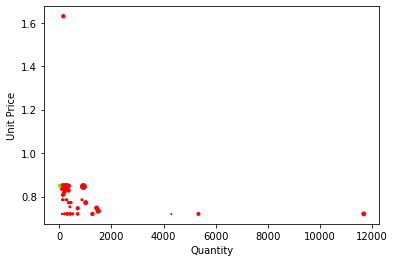

In [216]:
#product 1
plt.scatter(finalList[:-3,1], finalList[:-3,3], s=finalList[:-3,2], c=finalList[:-3,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
#Markers are sized by numbers of transactions

Text(0, 0.5, 'Unit Price')

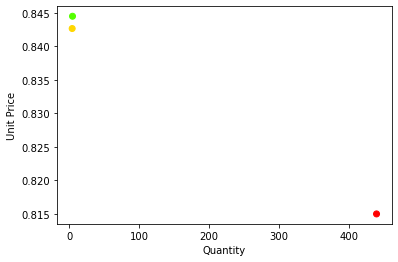

In [217]:
#product 1
plt.scatter(finalList[-3:,1], finalList[-3:,3], c=finalList[-3:,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')

Text(0, 0.5, 'Unit Price')

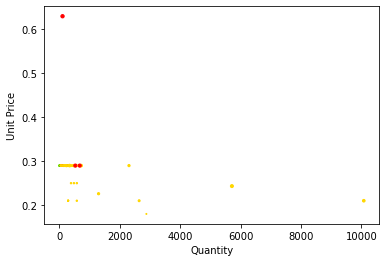

In [221]:
#product 2
plt.scatter(finalList[:-3,5], finalList[:-3,7], s=finalList[:-3,6], c=finalList[:-3,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
#Markers are sized by numbers of transactions

Text(0, 0.5, 'Unit Price')

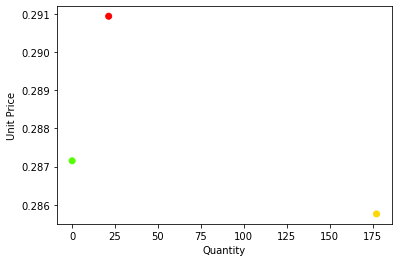

In [220]:
#product 2
plt.scatter(finalList[-3:,5], finalList[-3:,7], c=finalList[-3:,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')

Text(0, 0.5, 'Unit Price')

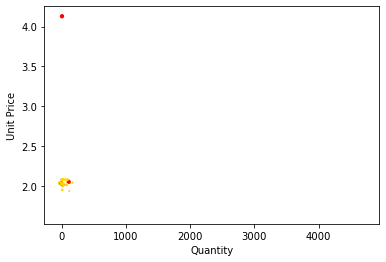

In [218]:
#product 3
plt.scatter(finalList[:-3,9], finalList[:-3,11], s=finalList[:-3,6], c=finalList[:-3,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')
#Markers are sized by numbers of transactions

Text(0, 0.5, 'Unit Price')

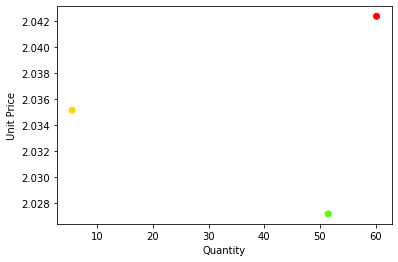

In [219]:
#product 3
plt.scatter(finalList[-3:,9], finalList[-3:,11], c=finalList[-3:,0], marker=None, cmap='prism')
plt.xlabel('Quantity')
plt.ylabel('Unit Price')

It does look like some of the points may be assigned incorrectly. Feature scaling or increasing the number of iterations could help with this. We should also play with the number of clusters.

But the algorithm seems to work more or less.

## Sci-Kit Learn K-Means Clustering <a class="anchor" id="third-bullet"></a>

Let's try to reproduce this result with the Sci-Kit Learn library.

In [30]:
from sklearn.cluster import KMeans

In [244]:
k=3
kmeans = KMeans(n_clusters = k, n_init = 10, init = 'random')
y_pred = kmeans.fit_predict(features.to_numpy())

In [228]:
kmeans.cluster_centers_

array([[0.00000000e+00, 0.00000000e+00, 8.41399720e-01, 0.00000000e+00,
        7.89600000e+03, 8.00000000e+00, 2.26666667e-01, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.03061236e+00, 0.00000000e+00],
       [2.46444644e+01, 9.83798380e-01, 8.41727532e-01, 3.63636364e-01,
        3.36840684e+01, 4.15841584e-01, 2.87240226e-01, 2.74527453e-01,
        4.05634563e+01, 1.49594959e+00, 2.03061236e+00, 5.72457246e-01],
       [7.11066667e+03, 8.33333333e+00, 7.20000000e-01, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.87131379e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.03061236e+00, 0.00000000e+00]])

In [230]:
unique, counts = np.unique(y_pred, return_counts=True)
print('clusters: ', unique, 'number of data points:',counts)

clusters:  [0 1 2] number of data points: [   2 1111    3]


In [231]:
kmeans.cluster_centers_ - finalList[-3:, 1:]

array([[-4.39870000e+02, -5.77000000e+00,  2.64028584e-02,
        -1.00000000e+00,  7.87471000e+03,  7.53000000e+00,
        -6.42663192e-02,  8.60000000e-01, -6.01400000e+01,
        -2.41000000e+00, -1.17895120e-02, -4.20000000e-01],
       [ 2.03493256e+01,  5.35881713e-01, -9.56257500e-04,
         2.14330808e-01, -1.43624959e+02, -1.05638064e+00,
         1.47865223e-03, -7.25472547e-01,  3.50704008e+01,
         9.40394039e-01, -4.55930396e-03,  3.46762801e-01],
       [ 7.10587546e+03,  7.76739927e+00, -1.24518503e-01,
         6.37362637e-01, -2.88461538e-02, -9.61538462e-03,
        -1.97020678e-05, -6.86813187e-03, -5.14697802e+01,
        -1.73214286e+00,  3.42311914e-03, -7.26648352e-01]])

So we get a very different results here but it is hard to compare because of the random initialization.

Let's stick to the Sci-Kit Learn library as they make it very easy and it has better options for centroid initilization, in addition to not having to choose the number of interations.

## Feature Scaling <a class="anchor" id="fourth-bullet"></a>

In [31]:
mean = pd.DataFrame(features.mean())
stdv = pd.DataFrame(features.std())

mean.head()
stdv

,0
Quantity1,417.545326
NumTransactions1,2.392064
UnitPrice1,0.030445
Prod1,0.481560
Quantity2,378.732258
NumTransactions2,0.999222
UnitPrice2,0.013614
Prod2,0.446760
Quantity3,211.509360
NumTransactions3,2.559931


In [32]:
mean = mean.to_numpy()
stdv = stdv.to_numpy()

mean = np.transpose(mean)
stdv = np.transpose(stdv)

In [33]:
print(mean.shape, stdv.shape)

(1, 12) (1, 12)


In [34]:
featuresArray = features.to_numpy()

#feature scaling
featuresScaled= (featuresArray - mean) / stdv

In [35]:
print(featuresArray.shape, featuresScaled.shape)  #sanity check

(1116, 12) (1116, 12)


In [36]:
np.set_printoptions(threshold=np.inf)

max = np.amax(featuresScaled, axis=0)
min = np.amin(featuresScaled, axis=0)
print('max:', max, '\n', 'min:', min)

max: [27.89721388 14.21291771 25.90205923  1.3192626  26.48920471 10.57991815
 25.18547343  1.62259603 22.03031716  9.57477027 22.797232    0.86835518] 
 min: [-0.10453654 -0.41879822 -3.98744818 -0.75732    -0.12590343 -0.428649
 -7.86935383 -0.61574411 -0.35167106 -0.58175288 -4.13306625 -1.15057061]


## Determining number of clusters <a class="anchor" id="fifth-bullet"></a>

In [45]:
elbow_data = np.array([])

for k in trange(1, 12):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(featuresScaled)
    elbow_data = np.append(elbow_data, values = [k, kmeans.inertia_])

In [86]:
elbow_data = elbow_data.reshape(-1, 2)

(0.0, 12.0)

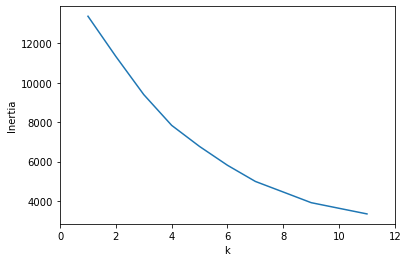

In [88]:
plt.plot(elbow_data[:,0], elbow_data[:,1])
plt.xlabel('k')
plt.ylabel('Inertia')
plt.xlim(0,12)

The 'elbow' seems to be around 8-11. Any where in this range is fine for the number of clusters. Let's try 8.

## Running the clustering model again with feature scaling and more clusters <a class="anchor" id="sixth-bullet"></a>

In [41]:
#Run the clustering model with k clusters
k=8
kmeans = KMeans(n_clusters = k)
y_pred = kmeans.fit_predict(featuresScaled)

In [42]:
unique, counts = np.unique(y_pred, return_counts=True)
print('clusters: ', unique, 'number of data points:',counts)

clusters:  [0 1 2 3 4 5 6 7] number of data points: [453 286 239   1   3  12   2 120]


We will first visualize the data by product. We will plot the data for quantity, unit price, and number of transactions. Next, we will plot the clusters that the algorithm found for those metrics.

(-5.0, 25.0)

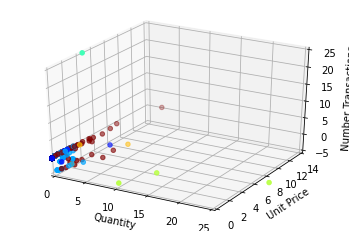

In [43]:
#Plot the data for product 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(featuresScaled[:,0], featuresScaled[:,1], featuresScaled[:,2], c = y_pred, cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

(-5.0, 25.0)

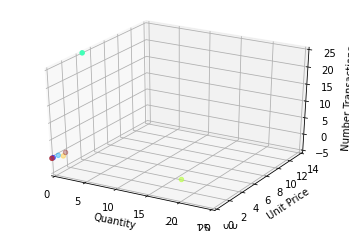

In [44]:
# where cluster centers are for product 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = [0, 1, 2, 3, 4, 5, 6, 7], cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

(-5.0, 25.0)

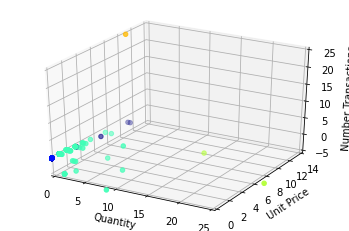

In [119]:
#Plot the data for product 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(featuresScaled[:,4], featuresScaled[:,5], featuresScaled[:,6], c = y_pred, cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

(-5.0, 25.0)

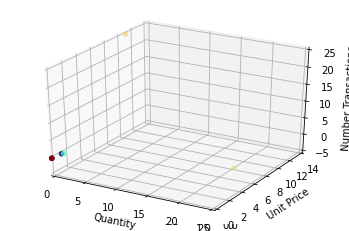

In [120]:
#Where are cluster centers for product 2
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,4], kmeans.cluster_centers_[:,5], kmeans.cluster_centers_[:,6], c = [0, 1, 2, 3, 4, 5, 6, 7], cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

(-5.0, 25.0)

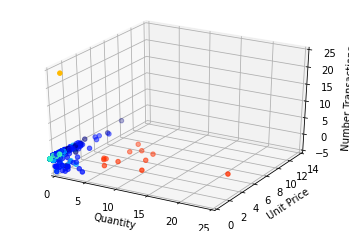

In [121]:
#Plot the data for product 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(featuresScaled[:,8], featuresScaled[:,9], featuresScaled[:,10], c = y_pred, cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

(-5.0, 25.0)

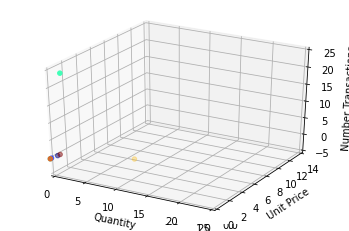

In [45]:
#Where are cluster centers for product 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,8], kmeans.cluster_centers_[:,9], kmeans.cluster_centers_[:,10], c = [0, 1, 2, 3, 4, 5, 6, 7], cmap = 'jet')
ax.set_xlabel('Quantity')
ax.set_ylabel('Unit Price')
ax.set_zlabel('Number Transactions')

ax.set_xlim((0, 25))
ax.set_ylim((0, 14))
ax.set_zlim((-5, 25))

Let's see what each cluster represents. Below there are color maps of the centroids.

On the horizonatal axis is 3 discrete columns for each product 1-3 from left to right. The vertical axis represents each of the centroids (8 in total).

There are 4 plots total for Quantity, Unit Price, Number of Transactions, classification-- if the product was sold or not.

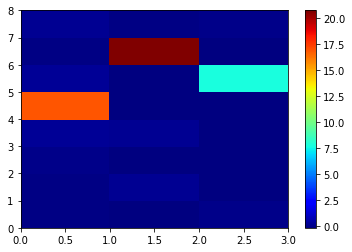

In [46]:
#Quantity
quantity_columns = [0, 4, 8]

plt.pcolor( kmeans.cluster_centers_[:, quantity_columns], cmap = 'jet' )
plt.colorbar()
plt.show()

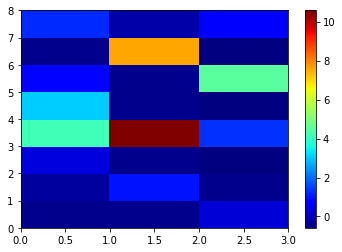

In [47]:
#Unit Price
UP_columns = [1, 5, 9]

plt.pcolor( kmeans.cluster_centers_[:, UP_columns], cmap = 'jet' )
plt.colorbar()
plt.show()

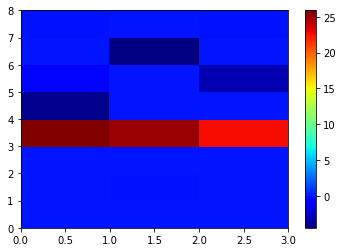

In [48]:
#Number of Transactions
num_trans_columns = [2, 6, 10]

plt.pcolor( kmeans.cluster_centers_[:, num_trans_columns], cmap = 'jet' ) 
plt.colorbar()
plt.show()

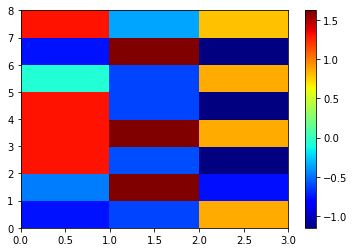

In [49]:
#Classification-- customer bought product or not
buy_prod_columns = [3, 7, 11]

plt.pcolor( kmeans.cluster_centers_[:, buy_prod_columns], cmap = 'jet' ) 
plt.colorbar()
plt.show()

Here's a summary of this info. Colors have been converted to low (L), medium (M), high (H).

| ///  | Q1 |UP1|#T1| P1 | Q2 | UP2 | #T2 | P2 | Q3 | UP3 | #T3 | P3 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---|
| 0 | L  | L | L  | L  | L  |  L | L | L  | L  | L | L |  H |
| 1 | L  | L | L  | L  | L  |  L | L | H  | L  | L | L |  L | 
| 2 | L  | L | L  |  H | L  | L  | L | L  |  L | L |L | L  |
| 3 | L  | M | H  | H  | L  |  H | H | H  | L  | L | H |  H | 
| 4 | H  | M | L  | H  | L  |  L | L | L  | L  | L | L | L  | 
| 5 | L  | L | L  | M  | L  |  L | L | L  | M  | M | L |  H | 
| 6 | L  | L | L  | L  | H  |  H | L | H  | L  | L | L |  L | 
| 7 | L  | L |  L | H  |  L | L  | L |  L |  L | L | L |  M |

**0th cluster:** Buys a lot of product 3 at a low price, not many transactions. Doesn't buy many of the other products.

**1th cluster:** Buys a lot of product 2 at a low price, not many transactions. Doesn't buy many of the other products.

**2th cluster:** Buys a lot of product 1 at a low price, not many transactions. Doesn't buy many of the other products.

**3th cluster:** Buys all 3 products and often, unit price varies depending on product.

**4th cluster:** Tends to buy product 1 for high prices and quantities, but does so infrequently.

**5rd cluster:** Buys products 1 and 3, pays more for product 3 than most. Does not place many transactions.

**6nd cluster:** Tends to buy product 2 for high prices and quantities, but does so infrequently.

**7st cluster:** Buys all mostly product 1 and 3, but places few orders with few quantities. Unit price is generally low.

The 5th and 7th cluster buy products 1 and 3 but the 7th cluster has a much better deal.

The 2nd and 4th cluster are also similar in that they mainly buy product 1, but the 4th cluster buys them at a higher price and buys more of them!

Let's have a look at the countries these customers are from to see if we can learn anything more there.

In [50]:
#add cluster prediction to the feature vector
featuresReset = features.reset_index(drop = False)
yPredDF = pd.DataFrame(y_pred)

clustersFeatures = pd.concat([featuresReset, yPredDF], axis = 1)

In [51]:
clustersFeatures

,index,Quantity1,NumTransactions1,UnitPrice1,Prod1,Quantity2,NumTransactions2,UnitPrice2,Prod2,Quantity3,NumTransactions3,UnitPrice3,Prod3,0
0,12359.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0
1,12362.0,36.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,7
2,12373.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,1.950000,1.0,0
3,12377.0,12.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,0.0,0.0,2.030612,0.0,2
4,12379.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111,18226.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,90.0,6.0,2.058333,1.0,0
1112,18235.0,0.0,0.0,0.8414,0.0,48.0,1.0,0.290000,1.0,10.0,1.0,2.080000,1.0,1
1113,18241.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,0
1114,18257.0,0.0,0.0,0.8414,0.0,48.0,1.0,0.290000,1.0,30.0,3.0,2.036667,1.0,1


In [52]:
clustersFeatures.set_index('index', inplace = True, drop = True)

In [53]:
clustersFeatures

,Quantity1,NumTransactions1,UnitPrice1,Prod1,Quantity2,NumTransactions2,UnitPrice2,Prod2,Quantity3,NumTransactions3,UnitPrice3,Prod3,0
index,,,,,,,,,,,,,
12359.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0
12362.0,36.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,7
12373.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,1.950000,1.0,0
12377.0,12.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,0.0,0.0,2.030612,0.0,2
12379.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18226.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,90.0,6.0,2.058333,1.0,0
18235.0,0.0,0.0,0.8414,0.0,48.0,1.0,0.290000,1.0,10.0,1.0,2.080000,1.0,1
18241.0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,0


In [65]:
#Get country info from the data dataframe
data.reset_index(inplace = True)

data.drop(['StockCode', 'InvoiceNo', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice'], axis = 1, inplace = True)
data.info

<bound method DataFrame.info of         CustomerID         Country
0          17850.0  United Kingdom
1          17850.0  United Kingdom
2          17850.0  United Kingdom
3          17850.0  United Kingdom
4          17850.0  United Kingdom
...            ...             ...
541904     12680.0          France
541905     12680.0          France
541906     12680.0          France
541907     12680.0          France
541908     12680.0          France

[541909 rows x 2 columns]>

In [67]:
data.drop_duplicates(inplace = True)
data.set_index('CustomerID', inplace = True)

In [68]:
data.nunique()

Country    38
dtype: int64

In [69]:
data.count()

Country    4389
dtype: int64

In [70]:
data.dtypes

Country    object
dtype: object

In [71]:
clustersFeatures.astype('object').dtypes

Quantity1           object
NumTransactions1    object
UnitPrice1          object
Prod1               object
Quantity2           object
NumTransactions2    object
UnitPrice2          object
Prod2               object
Quantity3           object
NumTransactions3    object
UnitPrice3          object
Prod3               object
0                   object
dtype: object

In [79]:
#Making new dataframe that has cluster number, feature info, and country info
clustersFeaturesData = clustersFeatures.join(data, how = 'left')
clustersFeaturesData.reset_index(drop = False, inplace = True)
clustersFeaturesData.drop(['index'], inplace = True, axis = 1)

In [80]:
clustersFeaturesData.info

<bound method DataFrame.info of       Quantity1  NumTransactions1  UnitPrice1  Prod1  Quantity2  \
0           0.0               0.0      0.8414    0.0        0.0   
1          36.0               1.0      0.8500    1.0        0.0   
2           0.0               0.0      0.8414    0.0        0.0   
3          12.0               1.0      0.8500    1.0        0.0   
4           0.0               0.0      0.8414    0.0        0.0   
...         ...               ...         ...    ...        ...   
1113        0.0               0.0      0.8414    0.0        0.0   
1114        0.0               0.0      0.8414    0.0       48.0   
1115        0.0               0.0      0.8414    0.0        0.0   
1116        0.0               0.0      0.8414    0.0       48.0   
1117        7.0               2.0      0.8500    1.0        0.0   

      NumTransactions2  UnitPrice2  Prod2  Quantity3  NumTransactions3  \
0                  0.0    0.287131    0.0       10.0               1.0   
1              

In [81]:
clustersFeaturesData.columns = ['Quantity1', 'NumTransactions1', 'UnitPrice1', 'Prod1', 'Quantity2', 'NumTransactions2', 'UnitPrice2', 'Prod2', 'Quantity3', 'NumTransactions3', 'UnitPrice3', 'Prod3', 'Cluster', 'Country']

In [83]:
clustersFeaturesData.groupby(['Cluster']).Country.nunique()

Cluster
0    16
1    12
2    11
3     1
4     1
5     2
6     1
7     7
Name: Country, dtype: int64

Text(0, 0.5, 'Number of Countries')

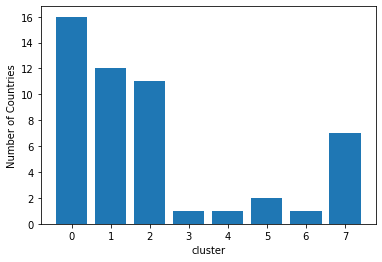

In [87]:
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).Country.nunique())

plt.xlabel('cluster')
plt.ylabel('Number of Countries')

So we can see that clusters 0, 1, 2, and 7 have customers from many countries, and the other clusters are made up of customers from 2 or less countries. Which countries, though?

In [88]:
clustersFeaturesData

,Quantity1,NumTransactions1,UnitPrice1,Prod1,Quantity2,NumTransactions2,UnitPrice2,Prod2,Quantity3,NumTransactions3,UnitPrice3,Prod3,Cluster,Country
0,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0,Cyprus
1,36.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,7,Belgium
2,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,1.950000,1.0,0,Austria
3,12.0,1.0,0.8500,1.0,0.0,0.0,0.287131,0.0,0.0,0.0,2.030612,0.0,2,Switzerland
4,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,10.0,1.0,2.080000,1.0,0,Belgium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,90.0,6.0,2.058333,1.0,0,United Kingdom
1114,0.0,0.0,0.8414,0.0,48.0,1.0,0.290000,1.0,10.0,1.0,2.080000,1.0,1,United Kingdom
1115,0.0,0.0,0.8414,0.0,0.0,0.0,0.287131,0.0,20.0,2.0,2.080000,1.0,0,United Kingdom
1116,0.0,0.0,0.8414,0.0,48.0,1.0,0.290000,1.0,30.0,3.0,2.036667,1.0,1,United Kingdom


In [89]:
clustersFeaturesData.groupby(['Country']).Cluster.unique()

Country
Australia                               [0]
Austria                                 [0]
Belgium                              [7, 0]
Canada                                  [1]
Channel Islands                      [0, 2]
Cyprus                               [0, 2]
Denmark                                 [1]
EIRE                                 [1, 7]
Finland                                 [0]
France                         [0, 1, 7, 2]
Germany                        [1, 0, 7, 2]
Israel                                  [2]
Italy                                [7, 2]
Japan                                   [1]
Netherlands                          [2, 5]
Norway                            [1, 2, 0]
Portugal                             [0, 1]
RSA                                     [0]
Singapore                               [7]
Spain                             [0, 1, 2]
Sweden                               [0, 1]
Switzerland                       [2, 0, 1]
USA                     

We see that customers from the UK are in all clusters. Customers making up clusters 3, 4, and 6 are exclusively UK. Cluster 5 is made up of customers from UK and Netherlands. Clusters 0-2 have customers all over the world (including in UK).

In [123]:
clustersFeaturesData.groupby(['Cluster', 'Country']).UnitPrice1.mean() * clustersFeaturesData.groupby(['Cluster', 'Country']).Quantity1.sum()

Cluster  Country        
0        Australia              0.000000
         Austria                0.000000
         Belgium                0.000000
         Channel Islands        0.000000
         Cyprus                 0.000000
         Finland                0.000000
         France                 0.000000
         Germany                0.000000
         Norway                 0.000000
         Portugal               0.000000
         RSA                    0.000000
         Spain                  0.000000
         Sweden                 0.000000
         Switzerland            0.000000
         USA                    0.000000
         United Kingdom         0.000000
1        Canada                 0.000000
         Denmark                0.000000
         EIRE                   0.000000
         France                20.234875
         Germany                0.000000
         Japan                  0.000000
         Norway                 0.000000
         Portugal               

In [122]:
clustersFeaturesData.groupby(['Cluster']).UnitPrice1.mean() * clustersFeaturesData.groupby(['Cluster']).Quantity1.sum()

Cluster
0        0.000000
1     2189.914659
2     7925.846848
3      247.760000
4    15359.040000
5     1560.351666
6        0.000000
7    11163.021709
dtype: float64

In [129]:
print('cluster 0: Nobody buys product 1')
print('cluster 1:', 2109.9/2189.9)
print('cluster 2:', 7073.3/7925.8)
print('cluster 3:', 247.76/247.8)
print('cluster 4:', 15359.0/15359.0)
print('cluster 5:', 1557.0/1560.35)
print('cluster 6: Nobody buys product 1')
print('cluster 7:', 9166.4/11163.0)

cluster 0: Nobody buys product 1
cluster 1: 0.9634686515365999
cluster 2: 0.8924398798859421
cluster 3: 0.9998385794995963
cluster 4: 1.0
cluster 5: 0.9978530457910085
cluster 6: Nobody buys product 1
cluster 7: 0.8211412702678491


In terms of revenue, the UK customer base is a very significant in all clusters for product 1 EXCEPT clusters 0 and 6 which do not buy it. I do not show it here but the story is similar for the other two products. The UK is a significant market for this business even in the clusters represented by more countries.

So which cluster is generating the most revenue? Is it the ones paying greater unit prices? More transactions? More items?

Text(0, 0.5, 'Revenue')

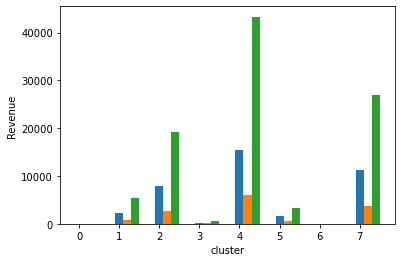

In [136]:
w = 0.2
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).UnitPrice1.mean() * clustersFeaturesData.groupby(['Cluster']).Quantity1.sum(), width = w)
plt.bar([0+w, 1+w, 2+w, 3+w, 4+w, 5+w, 6+w, 7+w], clustersFeaturesData.groupby(['Cluster']).UnitPrice2.mean()* clustersFeaturesData.groupby(['Cluster']).Quantity1.sum(), width = w)
plt.bar([0+(2*w), 1+(2*w), 2+(2*w), 3+(2*w), 4+(2*w), 5+(2*w), 6+(2*w), 7+(2*w)], clustersFeaturesData.groupby(['Cluster']).UnitPrice3.mean()* clustersFeaturesData.groupby(['Cluster']).Quantity1.sum(), width = w)
plt.xlabel('cluster')
plt.ylabel('Revenue')

So clusters 2, 4, and 7 generate the most revenue for all three products. Do these clusters place more orders? Order more products? Pay more per item? Let's see.

Text(0, 0.5, 'Mean Unit Price')

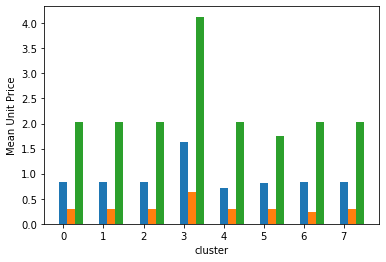

In [137]:
w = 0.2
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).UnitPrice1.mean(), width = w)
plt.bar([0+w, 1+w, 2+w, 3+w, 4+w, 5+w, 6+w, 7+w], clustersFeaturesData.groupby(['Cluster']).UnitPrice2.mean(), width = w)
plt.bar([0+(2*w), 1+(2*w), 2+(2*w), 3+(2*w), 4+(2*w), 5+(2*w), 6+(2*w), 7+(2*w)], clustersFeaturesData.groupby(['Cluster']).UnitPrice3.mean(), width = w)
plt.xlabel('cluster')
plt.ylabel('Mean Unit Price')

Text(0, 0.5, 'Number of Transactions')

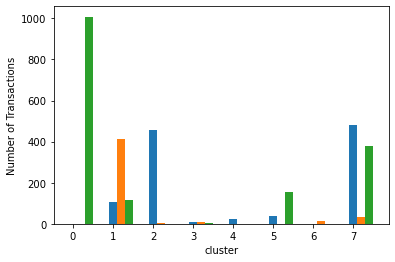

In [140]:
w = 0.2
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).NumTransactions1.sum(), width = w)
plt.bar([0+w, 1+w, 2+w, 3+w, 4+w, 5+w, 6+w, 7+w], clustersFeaturesData.groupby(['Cluster']).NumTransactions2.sum(), width = w)
plt.bar([0+(2*w), 1+(2*w), 2+(2*w), 3+(2*w), 4+(2*w), 5+(2*w), 6+(2*w), 7+(2*w)], clustersFeaturesData.groupby(['Cluster']).NumTransactions3.sum(), width = w)
plt.xlabel('cluster')
plt.ylabel('Number of Transactions')

Text(0, 0.5, '# Products sold')

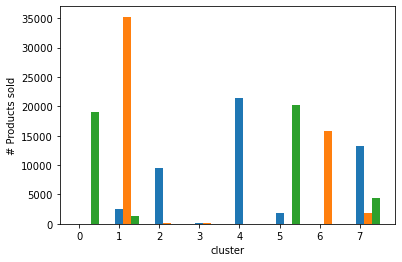

In [142]:
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).Quantity1.sum(), width = w)
plt.bar([0+w, 1+w, 2+w, 3+w, 4+w, 5+w, 6+w, 7+w], clustersFeaturesData.groupby(['Cluster']).Quantity2.sum(), width = w)
plt.bar([0+(2*w), 1+(2*w), 2+(2*w), 3+(2*w), 4+(2*w), 5+(2*w), 6+(2*w), 7+(2*w)], clustersFeaturesData.groupby(['Cluster']).Quantity3.sum(), width = w)
plt.xlabel('cluster')
plt.ylabel('# Products sold')

Text(0, 0.5, 'Products / transaction')

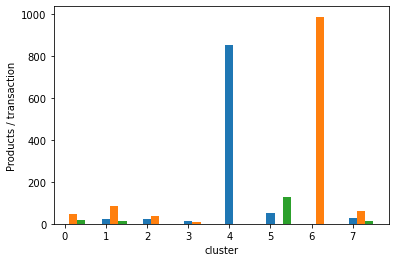

In [139]:
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], clustersFeaturesData.groupby(['Cluster']).Quantity1.sum() / clustersFeaturesData.groupby(['Cluster']).NumTransactions1.sum(), width = w)
plt.bar([0+w, 1+w, 2+w, 3+w, 4+w, 5+w, 6+w, 7+w], clustersFeaturesData.groupby(['Cluster']).Quantity2.sum() / clustersFeaturesData.groupby(['Cluster']).NumTransactions2.sum(), width = w)
plt.bar([0+(2*w), 1+(2*w), 2+(2*w), 3+(2*w), 4+(2*w), 5+(2*w), 6+(2*w), 7+(2*w)], clustersFeaturesData.groupby(['Cluster']).Quantity3.sum() / clustersFeaturesData.groupby(['Cluster']).NumTransactions3.sum(), width = w)
plt.xlabel('cluster')
plt.ylabel('Products / transaction')

It looks like clusters 2, 4, and 7 pay the mean unit price (except slightly lower for cluster 4 product 1). Clusters 2 and 7 had many transactions. In contrast, cluster 4 bought many products for each transaction (specifically for product 1). All three clusters mainly purchased product 1.

Other clusters sold higher quantities of product 2, however, this is a cheaper product (lower mean unit price) and therefore a smaller fraction of the total revenue.

So what countries (other than UK) generate the most revenue? 

In [143]:
data = pd.read_csv('data.csv', encoding = 'unicode_escape')
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [144]:
data.drop(['Description', 'InvoiceDate'], inplace = True, axis = 1)

In [145]:
data

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country
0,536365,85123A,6,2.55,17850.0,United Kingdom
1,536365,71053,6,3.39,17850.0,United Kingdom
2,536365,84406B,8,2.75,17850.0,United Kingdom
3,536365,84029G,6,3.39,17850.0,United Kingdom
4,536365,84029E,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...
541904,581587,22613,12,0.85,12680.0,France
541905,581587,22899,6,2.10,12680.0,France
541906,581587,23254,4,4.15,12680.0,France
541907,581587,23255,4,4.15,12680.0,France


In [146]:
data['transactionTotal'] = data.loc[:, 'Quantity'] * data.loc[:, 'UnitPrice']
revenueDF = data.groupby(['Country']).transactionTotal.sum()

<BarContainer object of 38 artists>

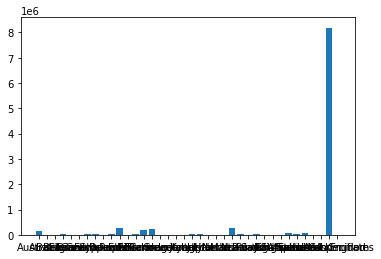

In [147]:
plt.bar(revenueDF.index, revenueDF)

In [148]:
revenueDF.sort_values(ascending = False)

Country
United Kingdom          8.187806e+06
Netherlands             2.846615e+05
EIRE                    2.632768e+05
Germany                 2.216982e+05
France                  1.974039e+05
Australia               1.370773e+05
Switzerland             5.638535e+04
Spain                   5.477458e+04
Belgium                 4.091096e+04
Sweden                  3.659591e+04
Japan                   3.534062e+04
Norway                  3.516346e+04
Portugal                2.936702e+04
Finland                 2.232674e+04
Channel Islands         2.008629e+04
Denmark                 1.876814e+04
Italy                   1.689051e+04
Cyprus                  1.294629e+04
Austria                 1.015432e+04
Hong Kong               1.011704e+04
Singapore               9.120390e+03
Israel                  7.907820e+03
Poland                  7.213140e+03
Unspecified             4.749790e+03
Greece                  4.710520e+03
Iceland                 4.310000e+03
Canada                  3.6663

The UK, Netherlands, Ireland, Germany, France, and Australia generate the most revenue (in desceding order).

In [149]:
QuantityDF = data.groupby(['Country']).Quantity.sum()

In [150]:
QuantityDF.sort_values(ascending = False)

Country
United Kingdom          4263829
Netherlands              200128
EIRE                     142637
Germany                  117448
France                   110480
Australia                 83653
Sweden                    35637
Switzerland               30325
Spain                     26824
Japan                     25218
Belgium                   23152
Norway                    19247
Portugal                  16180
Finland                   10666
Channel Islands            9479
Denmark                    8188
Italy                      7999
Cyprus                     6317
Singapore                  5234
Austria                    4827
Hong Kong                  4769
Israel                     4353
Poland                     3653
Unspecified                3300
Canada                     2763
Iceland                    2458
Greece                     1556
USA                        1034
United Arab Emirates        982
Malta                       944
Lithuania                   652


The same countries (in the exact same order) are buying the most products (in terms of number) from the company. Is the story the same for unit price?

In [151]:
UnitPriceDF = data.groupby(['Country']).UnitPrice.mean()

In [152]:
UnitPriceDF.sort_values(ascending = False)

Country
Singapore               109.645808
Hong Kong                42.505208
Portugal                  8.582976
Cyprus                    6.302363
Canada                    6.030331
Norway                    6.012026
EIRE                      5.911077
Finland                   5.448705
Lebanon                   5.387556
Malta                     5.244173
France                    5.028864
Spain                     4.987544
Channel Islands           4.932124
Greece                    4.885548
Italy                     4.831121
European Community        4.820492
Bahrain                   4.556316
United Kingdom            4.532422
Brazil                    4.456250
RSA                       4.277586
Austria                   4.243192
Poland                    4.170880
Germany                   3.966930
Sweden                    3.910887
Belgium                   3.644335
Israel                    3.633131
Switzerland               3.403442
United Arab Emirates      3.380735
Denmark     

No! The countries that spend the highest unit prices are Singapore, Hong Kong, Portugal, Cyprus, Canada, and Norway. 

There could be two reasons for this. One, those countries could be paying more for the same products. Or, they could just be purchasing the more expensive products.

## Summary <a class="anchor" id="seventh-bullet"></a>

We have used a K-means clustering algorithm to do a market segmentation analysis on an online shop selling gifts. We took the three most popular (most sold) gifts and segmented customers into 8 groups depending on what product they bought, the quantity sold of that product, the unit price of the product, the number of transactions they made for each product during the 9-month period of interest.

We found that UK customers made up a significant part of every segment. International customers tended to be in clusters 0, 1, 2, and 7 depending on which products they bought. Clusters 2, 4, and 7 generated the most revenue and each of these mainly bought product 1. Cluster 4 is made up of only 3 customers. They are important customers for product 1.

The UK generates the most revenue by far and purchases the most products. In terms of the international market  Netherlands, Ireland, Germany, France, and Australia are the countries that buy the most products and generate the most revenue on the site. However, 38 countries purchased gifts from the site during this time. We should look into expanding the customer base in these countries. In particular, Singapore, Hong Kong, Portugal, Cyprus, Canada, and Norway paid the highest prices per item. We could look into appealing to these customers more to try and get them to buy more products.

Data can be found here: https://archive.ics.uci.edu/ml/datasets/online+retail